In [1]:
%pylab inline
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import psycopg2

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', size=12, family='serif')

## Get Data Entered by Observers

This section takes the Time Use input by the observers (LO) in the nightlog and collates it all. 

In [119]:
#Run this cell to get all the data from the NightLogs
nl_dir = '/global/cfs/cdirs/desi/survey/ops/nightlogs'

time_use_files = {}
for dir_ in os.listdir(nl_dir):
    f = os.path.join(nl_dir,dir_,'time_use_kpno.csv')
    if os.path.isfile(f):
        time_use_files[dir_] = f
        
data = []
for date, f in time_use_files.items():
    df = pd.read_csv(f)
    d = df.iloc[0]
    data.append([date, d['obs_time'], d['test_time'], d['inst_loss'],d['weather_loss'], d['tel_loss'], d['18deg'],d['total']])        

nl_df = pd.DataFrame(data, columns = ['date','obs_time', 'test_time', 'inst_loss','weather_loss', 'tel_loss','18deg', 'total'])
nl_df = nl_df[['date','obs_time', 'test_time', 'inst_loss','weather_loss', 'tel_loss']]
nl_df = nl_df.astype({"date": int64})

In [120]:
##If you need to add a line that isn't being read by nightlog for whatever reason, you can add another line manually here:
##df.loc[df.shape[0]] = [date,obs_time,test_time,isnt_loss,weather_loss,tel_loss]
#df.loc[df.shape[0]] = ['20210901',0,0,8.324,0,0]

In [121]:
#Run this to add to the existing file
df = pd.read_csv('time_use_master.csv')
for date in list(nl_df.date):
    if date not in list(df.date):
        print('Adding data for:',date)
        d_ = nl_df[nl_df.date == date]
        df = df.append(d_)
df.sort_values('date',inplace=True)
df.drop_duplicates('date',inplace=True,keep='first') #There shouldn't be any, but just in case
df.to_csv('time_use_master.csv',index=False)

In [122]:
#Format things so easier to plot
df = df.astype({"date": str})
df.set_index('date',inplace=True)
df.columns = ['Observing','Testing','Inst. Loss','Weather Loss','Tel. Loss']

## Plot Time Use Data

In [123]:
# Enter the date that you want data after for
date = '20210930'
this_df = df[df.index > date]
print(this_df)

          Observing   Testing  Inst. Loss  Weather Loss  Tel. Loss
date                                                              
20211001  10.250000  0.000000    0.250000      0.000000   0.000000
20211002   9.500000  0.000000    0.250000      0.750000   0.000000
20211003   3.500000  0.000000    0.000000      7.000000   0.000000
20211004   0.000000  0.000000    1.000000      9.500000   0.000000
20211005   9.470000  0.000000    0.150000      0.900000   0.000000
20211006   6.460000  0.170000    0.000000      3.920000   0.000000
20211007   4.170000  0.000000    0.000000      6.420000   0.000000
20211008  10.000000  0.000000    0.000000      0.000000   0.000000
20211009   9.120000  0.000000    0.880000      0.000000   0.000000
20211010   9.633000  0.000000    1.017000      0.000000   0.000000
20211011   0.000000  0.000000    0.000000     10.720000   0.000000
20211012   0.000000  0.000000    0.000000     10.700000   0.000000
20211013   9.816667  0.000000    0.000000      0.000000   0.00

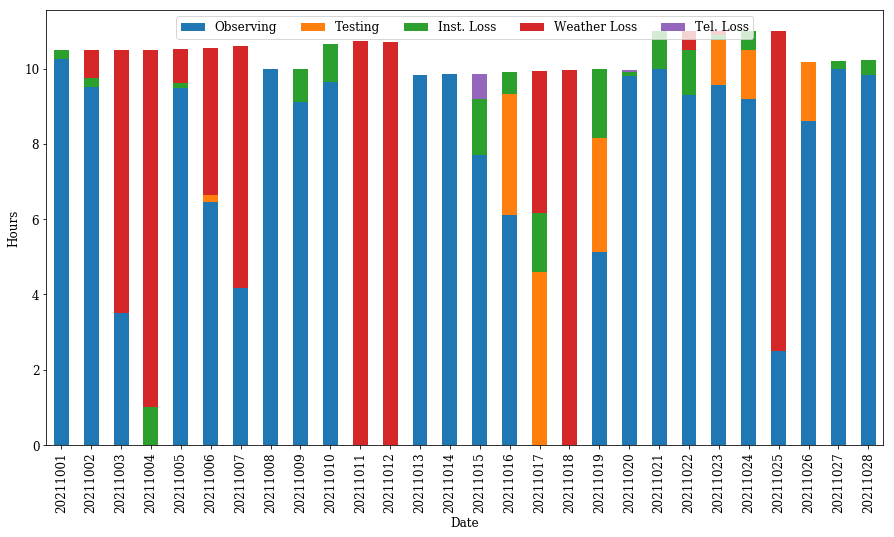

In [124]:
#Plot all data after date above
ax = this_df.plot.bar(stacked=True, figsize=(15,8))
ax.set_ylabel("Hours")
ax.set_xlabel("Date")
ax.legend(loc='upper center',ncol=len(this_df.columns))

## Monthly Statistics

In [125]:
month_stats = pd.read_csv('time_use_month_summary.csv')

In [126]:
month_stats

,Month,Observing,Testing,Inst. Loss,Weather Loss,Tel. Loss,DESI5577_Q1,DESI5577_AV,DESI5577_Q3
0,January,0.327600,0.067800,0.118800,0.051900,0.434000,0.7755,0.6864,0.5980
1,February,0.341400,0.295200,0.042700,0.167400,0.153300,0.7744,0.7099,0.6316
2,March,0.346900,0.154300,0.073600,0.231900,0.193200,0.8076,0.7873,0.7486
3,April,0.590500,0.177300,0.057300,0.113300,0.061700,0.8902,0.8177,0.7891
4,May,0.697700,0.035600,0.068300,0.083200,0.115200,0.8970,0.8850,0.7998
5,June,0.660000,0.106000,0.045500,0.159900,0.028600,0.9441,0.9131,0.7503
6,July,0.114700,0.003800,0.654000,0.226800,0.000700,0.5077,0.4387,0.3984
7,August,0.000000,0.000000,1.000000,0.000000,0.000000,0.6925,0.5180,0.4820
8,September,0.165000,0.117600,0.547600,0.167800,0.001900,0.7686,0.6320,0.6000
9,October,0.652094,0.051777,0.043405,0.250258,0.002466,0.0000,0.0000,0.0000


### Add a Month

In [127]:
month_name = 'October'
date_start = '20210930'
date_end = '20211101'

In [128]:
#Run this to add the line to the month_stats and resave the file
month_df = df[(df.index > date_start) & (df.index < date_end)]
month_perc = month_df.sum()/month_df.sum().sum()
add_line = pd.DataFrame([[month_name, month_perc['Observing'], month_perc['Testing'], month_perc['Inst. Loss'], month_perc['Weather Loss'], 
            month_perc['Tel. Loss'], 0, 0, 0]], columns=month_stats.columns)
month_stats = month_stats.append(add_line)
month_stats.to_csv('time_use_month_summary.csv',index=False)

In [129]:
month_stats

,Month,Observing,Testing,Inst. Loss,Weather Loss,Tel. Loss,DESI5577_Q1,DESI5577_AV,DESI5577_Q3
0,January,0.327600,0.067800,0.118800,0.051900,0.434000,0.7755,0.6864,0.5980
1,February,0.341400,0.295200,0.042700,0.167400,0.153300,0.7744,0.7099,0.6316
2,March,0.346900,0.154300,0.073600,0.231900,0.193200,0.8076,0.7873,0.7486
3,April,0.590500,0.177300,0.057300,0.113300,0.061700,0.8902,0.8177,0.7891
4,May,0.697700,0.035600,0.068300,0.083200,0.115200,0.8970,0.8850,0.7998
5,June,0.660000,0.106000,0.045500,0.159900,0.028600,0.9441,0.9131,0.7503
6,July,0.114700,0.003800,0.654000,0.226800,0.000700,0.5077,0.4387,0.3984
7,August,0.000000,0.000000,1.000000,0.000000,0.000000,0.6925,0.5180,0.4820
8,September,0.165000,0.117600,0.547600,0.167800,0.001900,0.7686,0.6320,0.6000
9,October,0.652094,0.051777,0.043405,0.250258,0.002466,0.0000,0.0000,0.0000


### Plot It!

In [130]:
month_stats.set_index('Month',inplace=True)

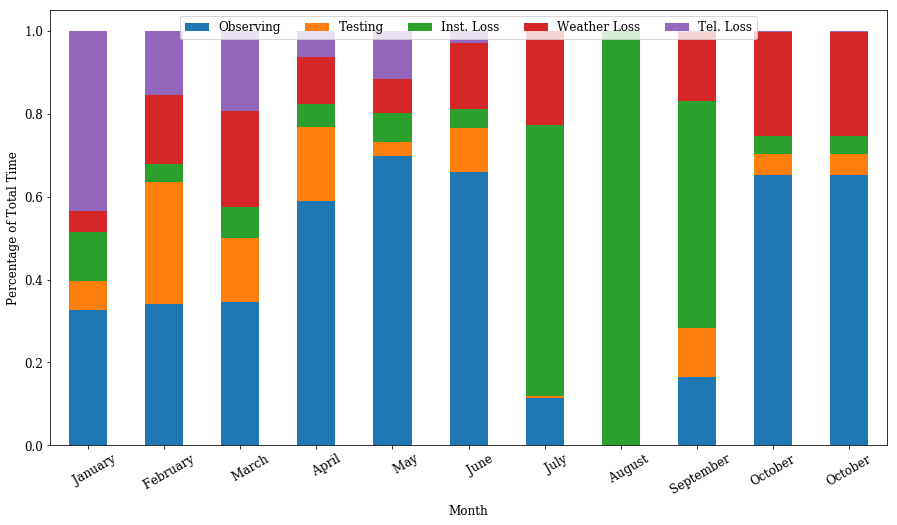

In [131]:
#Plot it!
fig, ax = plt.subplots(figsize=(15, 8))
month_stats[['Observing', 'Testing', 'Inst. Loss', 'Weather Loss','Tel. Loss',]].plot.bar(stacked=True, rot=30, ax=ax)
#month_stats.plot(y='DESI5577_Q1',style='ko-', ax=ax)
#month_stats.plot(y='DESI5577_AV',style='k.--', ax=ax)
#month_stats.plot(y='DESI5577_Q3',style='k.-.', ax=ax)

ax.set_ylabel('Percentage of Total Time')
ax.legend(loc='upper center',ncol=5)
#plt.plot(month_stats.index, month_stats['DESI5577_Q3'], 'o-', label = 'DESI5557_Q3')
#plt.plot(month_stats.index, month_stats['DESI5577_AV'], 'o-', label = 'DESI5557_AV')

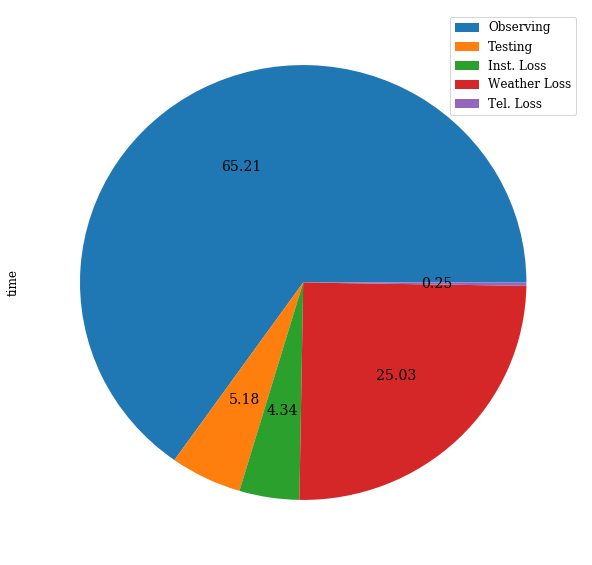

In [132]:
#Pie Chart for one month
month = 'October'

df = month_stats[month_stats.index == month][['Observing', 'Testing', 'Inst. Loss', 'Weather Loss','Tel. Loss']]
pie_df = pd.DataFrame(columns=['time','names'])
pie_df['time'] = df.iloc[0].values
pie_df['names'] = df.columns

fig, ax = plt.subplots(1, figsize=(10,10))
pie_df.set_index('names').plot.pie(y='time',ax=ax, autopct='%.2f',labels=None, fontsize=14)

## Collect data from DataBase

In [133]:
conn = psycopg2.connect(host="db.replicator.dev-cattle.stable.spin.nersc.org", port="60042", database="desi_dev", user="desi_reader", password="reader")

In [134]:
exp_df = pd.read_sql_query("SELECT * FROM exposure WHERE night > '{}'".format(date), conn) #Uses date entered above

In [135]:
date

'20210930'

In [136]:
#Gets how many exposures were completed every night
total = 0
for date in np.unique(exp_df.night):
    sci = exp_df[(exp_df.night == date) & (exp_df.sequence == 'DESI')]
    total+=len(sci)
    print(date, len(sci))

20211001 36
20211002 29
20211003 18
20211004 0
20211005 25
20211006 20
20211007 12
20211008 32
20211009 26
20211010 32
20211011 0
20211012 0
20211013 27
20211014 24
20211015 34
20211016 47
20211017 17
20211018 7
20211019 41
20211020 28
20211021 31
20211022 29
20211023 40
20211024 39
20211025 6
20211026 35
20211027 26
20211028 31
20211029 0


## Advanced - Under work

In [138]:
#This is Klaus's stuff. Need to make a cleaner interface and call only a certain amount of data
accumulated_df = pd.read_sql_query("SELECT * FROM performance_accumulated WHERE obsday>'{}'".format(date), conn)

In [139]:
accumulated_df.head()

,performance_accumulated,system_ready,nfs,ocs_active,guider_loop,focus_loop,sky_loop,illuminator,specman_shutter,specman_digitize,...,about_to_stop,stop_request,monitored,time_between_twilight,handle_fvc,gfaadjust,nfsadjust,surveyobs,obs,nfsrequest


In [43]:
ICS_Data = []
for date in dates:
    ics = accumulated_df[accumulated_df['obsday'] == date][['idle','opsstate','weather','instrument','mayall','other','acquisition','specman_shutter','time_between_twilight']]
    ics['observing'] = ics['acquisition'] + ics['specman_shutter']
    if len(ics)> 0:
        x = -1
        empty = True
        while empty:
            if ics.iloc[x]['opsstate'] == float(0):
                x += -1
            else:
                total_time = ics.iloc[x]['time_between_twilight']/3600.
                b = ics.iloc[x]/3600.
                empty = False
        ICS_Data.append([date,b.observing,b.idle,b.weather,b.instrument,b.mayall,b.other])
ICS_df = pd.DataFrame(ICS_Data, columns = ['date','observing','idle','weather','instrument','mayall','other'])
ICS_df.sort_values('date',inplace=True)
ICS_df.set_index('date',inplace=True)

Text(0.5,0,'Date')

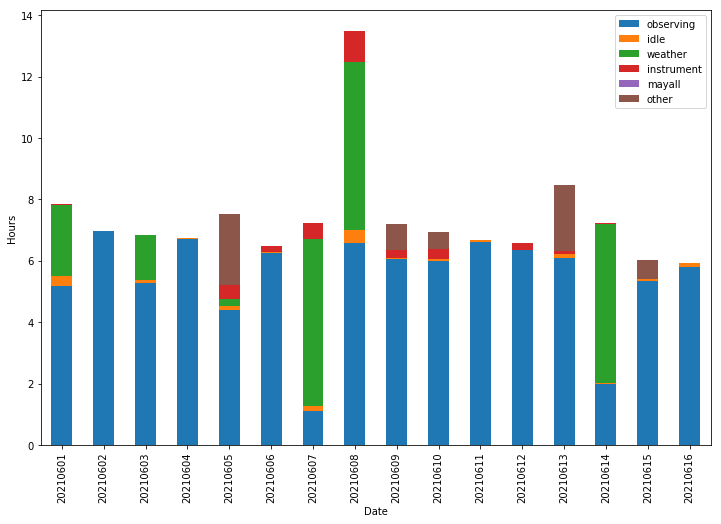

In [46]:
ax = ICS_df.plot.bar(stacked=True, figsize=(12,8))
ax.set_ylabel("Hours")
ax.set_xlabel("Date")

## Compare Inputs from Observers to ICS DB

In [56]:
def compare_plots(date):
    ics = accumulated_df[accumulated_df['obsday'] == date][['idle','opsstate','weather','instrument','mayall','other','acquisition','specman_shutter','time_between_twilight']]

    ics['observing'] = ics['acquisition'] + ics['specman_shutter']
    x = -1
    empty = True
    while empty:
        if ics.iloc[x]['opsstate'] == float(0):
            x += -1
        else:
            total_time = ics.iloc[x]['time_between_twilight']/3600.
            b = ics.iloc[x]/3600./total_time
            empty = False
            
    observers = df[df.index == date]
    observers.rename(columns={'obs_time':'observing','test_time':'testing','inst_loss':'instrument','tel_loss':'mayall','weather_loss':'weather'},inplace=True)
    a = observers.iloc[0]/total_time
    
    data = [[a.observing,0,a.weather,a.instrument,a.mayall,0,a.testing],
       [b.observing,b.idle,b.weather,b.instrument,b.mayall,b.other,0]]
    new_df = pd.DataFrame(data,columns=['observing','idle','weather','instrument','mayall','other','testing'])
    new_df.index = ['Observers','ICS']
    
    new_df.plot.bar(stacked=True,figsize=(8,6))

    x = 0
    for i, row in new_df.iterrows():
        plt.text( x-0.1, row.sum()+.05,str(np.round(row.sum(),3)), va='center')
        x += 1
    plt.title(date)
    plt.ylabel("% of Total Time: {:.3f} hrs".format(total_time))
    plt.axhline(1.,c='k',ls='--')
    y_high = np.max([1,new_df.loc['Observers'].sum(), new_df.loc['ICS'].sum()])
    plt.ylim(0,y_high+0.1)
    return new_df

,observing,idle,weather,instrument,mayall,other,testing
Observers,0.587513,0.000000,0.572337,0.01084,0.0,0.0,0.0
ICS,0.259177,0.005357,0.671102,0.00464,0.0,0.0,0.0


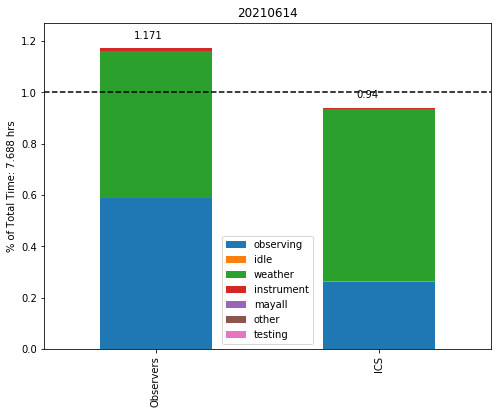

In [64]:
compare_plots('20210614')